## Imports

In [336]:
import os
import numpy as np
import pandas as pd
import hypertools as hyp
from umap import UMAP
from os.path import join as opj
from scipy.interpolate import interp1d
from scipy.stats import pearsonr
from scipy.spatial.distance import cdist

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## Set paths

In [2]:
datadir = '../data-analysis/'
traj_dir = opj(datadir, 'trajectories')
fig_dir = '../../figures/'

## Load data

In [136]:
questions_df = pd.read_csv('../data-analysis/astronomyquestions.tsv', sep='\t', 
            names=['index', 'video', 'question', 'ans_A', 'ans_B', 'ans_C', 'ans_D'], index_col='index') 

sub_data = dict()
data_df = pd.read_csv('../graded-answers/Graded_results_19s.csv', index_col='Unnamed: 0')
for sub in data_df.participantID.unique():
    sub_data[sub] = data_df.loc[data_df.participantID == sub].drop('participantID', axis=1).reset_index(drop=True)

forces_vid = np.load(opj(traj_dir, 'forces_v_traj.npy'))
bos_vid = np.load(opj(traj_dir, 'bos_v_traj.npy'))
forces_qs = np.load(opj(traj_dir, 'forces_q_traj.npy'))
bos_qs = np.load(opj(traj_dir, 'bos_q_traj.npy'))

qsets = ['qset1', 'qset2', 'qset3']
forces_traces = dict.fromkeys(qsets)
bos_traces = dict.fromkeys(qsets)
for qset in range(1, 4):
    fq_path = opj(traj_dir, f'forces_traces_set{qset - 1}.p')
    bq_path = opj(traj_dir, f'bos_traces_set{qset - 1}.p')
    forces_traces[f'qset{qset}'] = np.load(fq_path, allow_pickle=True)
    bos_traces[f'qset{qset}'] = np.load(bq_path, allow_pickle=True)
    
CV = np.load(opj(datadir, 'fit_CV.npy'), allow_pickle=True).item()
LDA = np.load(opj(datadir, 'fit_LDA.npy'), allow_pickle=True).item()

## Create 2D embeddings

In [4]:
seed = 0
umap_params = {
    'n_components': 2,
    'n_neighbors': 15,
    'spread': 1.0,
    'min_dist': 0.1,
    'metric': 'correlation',
    'init': 'random',
    'random_state': seed,
}

In [5]:
# embedding all videos, questions, traces together
to_reduce = [forces_vid] + [bos_vid] + [forces_qs] + [bos_qs]
for vid_traces in [forces_traces, bos_traces]:
    for qset_traces in vid_traces.values():
        for sub in sorted(list(qset_traces.keys())):
            to_reduce.append(qset_traces[sub])

In [6]:
split = np.cumsum([len(traj) for traj in to_reduce])[:-1]
stacked_trajs = np.vstack(to_reduce)

np.random.seed(seed)
reducer = UMAP(**umap_params).fit(stacked_trajs)
stacked_embeddings = reducer.transform(stacked_trajs)
embeddings = np.vsplit(stacked_embeddings, split)

In [7]:
# np.save(opj(datadir, 'embeddings.npy'), embeddings)
# np.save(opj(datadir, 'UMAP_reducer.npy'), reducer)
embeddings = np.load(opj(datadir, 'embeddings.npy'))
reducer = np.load(opj(datadir, 'UMAP_reducer.npy'), allow_pickle=True).item()

In [8]:
forces_vid_emb, bos_vid_emb, forces_qs_emb, bos_qs_emb = embeddings[:4]
forces_traces_embs = {qset: {sub: None for sub in range(1, 41)} for qset in qsets}
bos_traces_embs = {qset: {sub: None for sub in range(1, 41)} for qset in qsets}

ix = 4
for trace_emb_dict in [forces_traces_embs, bos_traces_embs]:
    for qset in qsets:
        for sub in sorted(list(forces_traces[qset].keys())):
            
            trace_emb_dict[qset][sub] = embeddings[ix]
            ix += 1

## Create a 2D grid

In [57]:
scale = np.max([np.abs(i) for i in [forces_vid_emb.min(), 
                                    forces_vid_emb.max(), 
                                    bos_vid_emb.min(), 
                                    bos_vid_emb.max()]]) // 1 + 1

step = scale / 25
print(f'scale: {scale}, step: {step}')

X, Y = np.meshgrid(np.arange(-scale, scale, step), np.arange(-scale, scale, step))
xy_grid = np.empty((50, 50, 2), dtype=np.float16)
for (x_ix, y_ix), X_val in np.ndenumerate(X):
    xy_grid[x_ix, y_ix] = (X_val, Y[x_ix, y_ix])

scale: 31.0, step: 1.24


In [120]:
# compute original topic proportions at each vertex
vertices = xy_grid.reshape(2500, 2)
topic_space_grid = reducer.inverse_transform(vertices).reshape(50, 50, -1)

# inverse transform fails for some gridpoints with little surrounding data 
# deal with these by interpolating topic vectors from surround successfully produced topic vectors
err_points = np.where(np.all(np.equal(topic_space_grid, 0), axis=2))



In [208]:
n_questions = len(questions_df.loc[questions_df.video.isin([1, 2])])
participant_IDs = sorted(data_df.participantID.unique())

In [281]:
question_corr_grid = np.empty((n_questions, X.shape[0], X.shape[1]))
all_questions_vectors = list(forces_qs) + list(bos_qs)

for q_n, q_vector in enumerate(all_questions_vectors):
    for x_ix in range(X.shape[0]):
        for y_ix in range(X.shape[1]):
            question_corr_grid[q_n, x_ix, y_ix] = pearsonr(q_vector, topic_space_grid[x_ix, y_ix])[0]

In [259]:
for set_n in range(3):
    questions_pcorrect = np.empty(n_questions)
    for question in range(n_questions):
        # questions 1 - 30 pertain to lectures
        set_views = data_df.loc[(data_df.qID == question + 1) & (data_df['set'] == set_n)]
        p_correct = len(set_views.loc[set_views['correct?'] == 1]) / len(set_views)
        questions_pcorrect[question] = p_correct
        
    # compute weighted proportion of correctly answered questions for ecah grid point
    # weights are correlation between grid point topic vector and question vector
    knowledge_grid = np.zeros_like(X)
    weight_sum = question_corr_grid.sum(axis=0)
    knowledge_grid = (questions_pcorrect * question_corr_grid.T).sum(axis=2) / weight_sum
    
    

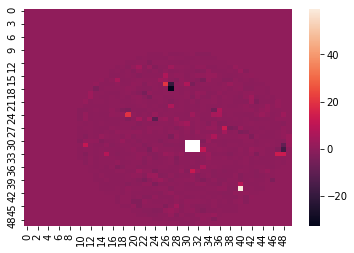

In [265]:
sns.heatmap(knowledge_grid)
plt.show()

In [325]:
all_zeros = xy_grid[np.where(np.isnan(knowledge_grid))]

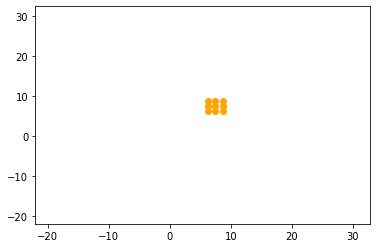

In [335]:
plt.scatter(np.vstack(embeddings)[:, 0], np.vstack(embeddings)[:, 1], c='white')
plt.scatter(all_zeros[:, 0], all_zeros[:, 1], c='orange')
plt.show()

In [345]:
np.where(np.isnan(knowledge_grid))

(array([30, 30, 30, 31, 31, 31, 32, 32, 32]),
 array([30, 31, 32, 30, 31, 32, 30, 31, 32]))

(array([30, 30, 30, 31, 31, 31, 32, 32, 32]),
 array([30, 31, 32, 30, 31, 32, 30, 31, 32]))